In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import additional necessary libraries

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Apparently numpy can't do everything
import statistics as stats

# SKLearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans

# Warnings
import warnings

In [3]:
# Ignore the warnings
warnings.filterwarnings('ignore')

# Credit Card Customer Segmentation

This dataset includes the usage behavior of about 9,000 active credit card holders for a period of six months for a particular company. The aim is to use clustering to develop a customer segmentation which will define marketing strategies.

**Strategy**

1. Analyze & preprocess data: perform EDA, fill in missing values, and scale data for KMeans clustering algorithm.
2. Build/train KMeans clustering algorithm: determine best value of $k$ using elbow plot, tune other model hyperparameters.
3. Build/train the final model. Investigate data as it is clustered.
4. Discussion & Conclusion.

**Dataset Available Here:** https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data

# Step 1: Exploratory Data Analysis & Preprocessing

## Step 1A: Initial Examination & Fill Missing Values

In [4]:
# Load dataset
df = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')
print(f"Size of data: {df.shape}")
df.head()

Size of data: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
print(df.describe())

            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000

In [5]:
# Set 'CUST_ID' as the index.
df.set_index("CUST_ID",inplace=True)

# Examine data nulls and duplicates.
print("Missing Data:")
print(df.isnull().sum())
print("\nDuplicate Data:")
print(df.duplicated().sum())

Missing Data:
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Duplicate Data:
0


There are a few missing data values here -- one in the CREDIT_LIMIT, and 313 in MINIMUM_PAYMENTS. I will fill these with the means values for each of their columns.

In [6]:
# Fill missing data.
df.MINIMUM_PAYMENTS.fillna(df.MINIMUM_PAYMENTS.mean(),inplace=True)
df.CREDIT_LIMIT.fillna(df.CREDIT_LIMIT.mean(),inplace=True)

## Step 1B: Visualize Data

Here I will examine the data visually. Using $\verb+df.describe()+$ has already helped me to get a basic feel of the data, but as the saying goes, a picture is worth a thousand words.

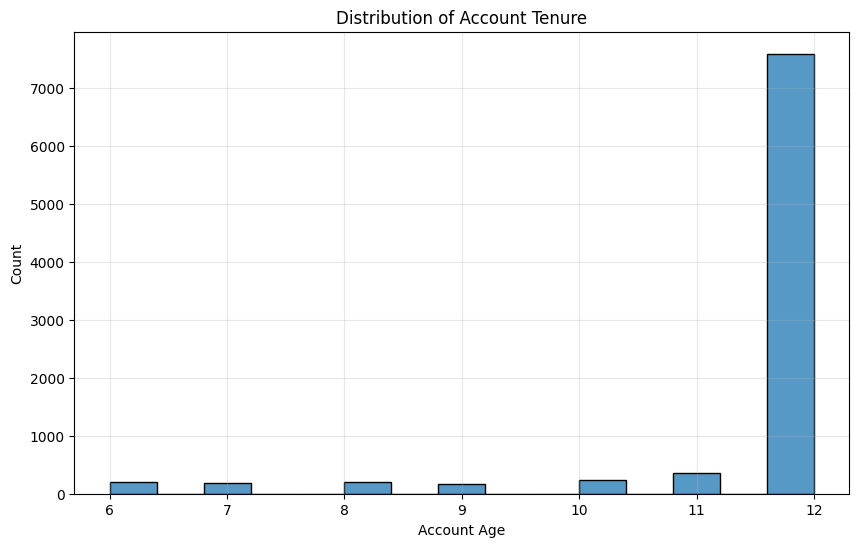

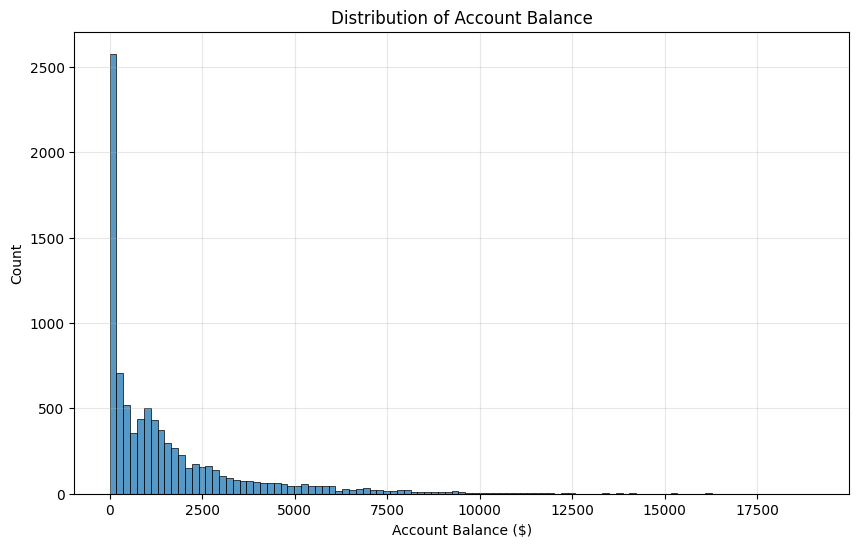

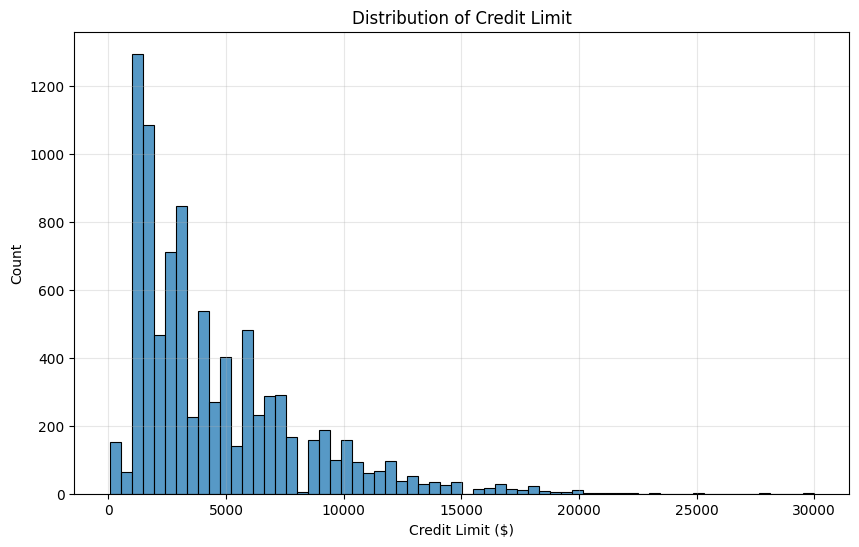

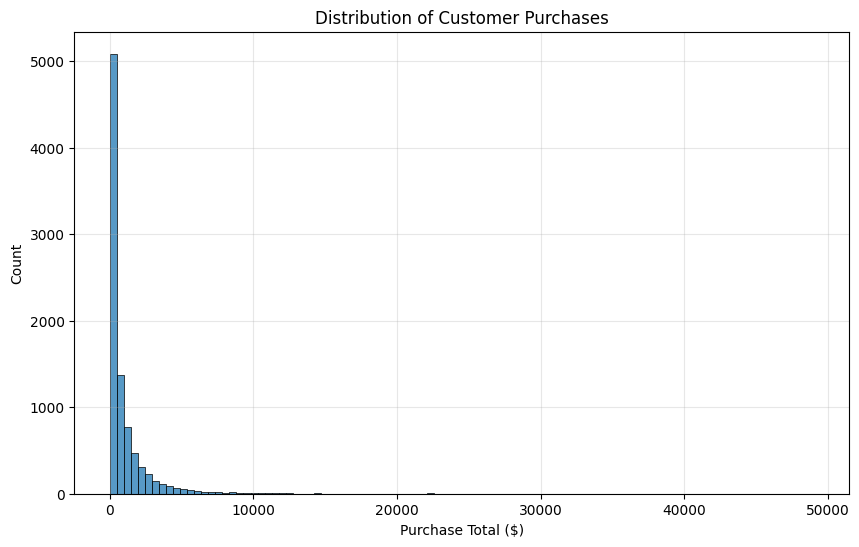

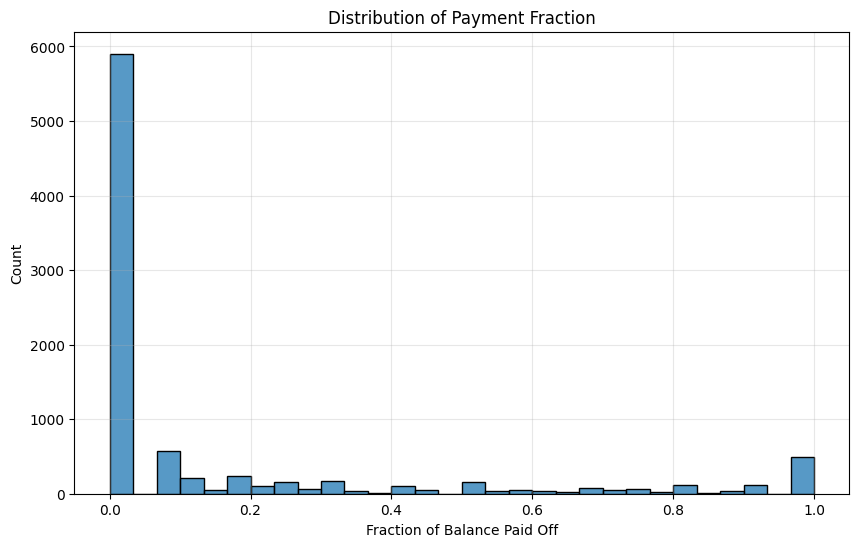

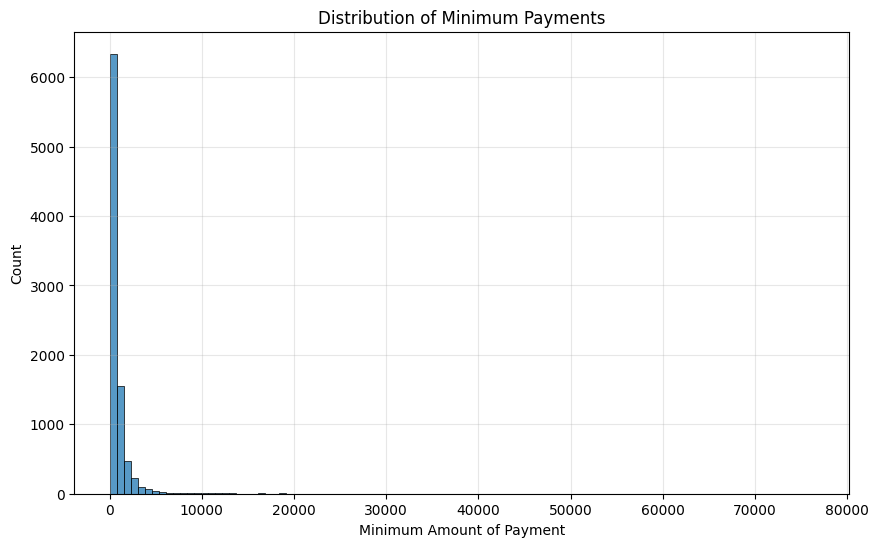

In [8]:
# Inspect a few columns individually.

# TENURE Histogram
plt.figure(figsize=(10,6))
sns.histplot(df.TENURE)
plt.title("Distribution of Account Tenure")
plt.xlabel("Account Age")
plt.ylabel("Count")
plt.grid(True,alpha=0.3)
plt.show()

# BALANCE Histogram
print("\n")
plt.figure(figsize=(10,6))
sns.histplot(df.BALANCE)
plt.title('Distribution of Account Balance')
plt.xlabel("Account Balance ($)")
plt.ylabel("Count")
plt.grid(True,alpha=0.3)
plt.show()

# CREDIT LIMIT Histogram
print("\n")
plt.figure(figsize=(10,6))
sns.histplot(df.CREDIT_LIMIT)
plt.title('Distribution of Credit Limit')
plt.xlabel("Credit Limit ($)")
plt.ylabel("Count")
plt.grid(True,alpha=0.3)
plt.show()

# PURCHASES Histogram
print("\n")
plt.figure(figsize=(10,6))
sns.histplot(df.PURCHASES,bins=100)
plt.title('Distribution of Customer Purchases')
plt.xlabel("Purchase Total ($)")
plt.ylabel("Count")
plt.grid(True,alpha=0.3)
plt.show()

# PRC_FULL_PAYMENT Histogram
print("\n")
plt.figure(figsize=(10,6))
sns.histplot(df.PRC_FULL_PAYMENT,bins=30)
plt.title('Distribution of Payment Fraction')
plt.xlabel("Fraction of Balance Paid Off")
plt.ylabel("Count")
plt.grid(True,alpha=0.3)
plt.show()

# MINIMUM_PAYMENTS
print("\n")
plt.figure(figsize=(10,6))
sns.histplot(df.MINIMUM_PAYMENTS,bins=100)
plt.title('Distribution of Minimum Payments')
plt.xlabel("Minimum Amount of Payment")
plt.ylabel("Count")
plt.grid(True,alpha=0.3)
plt.show()

In [7]:
print("\n Interesting Statistics:")
ten12 = (len(df.TENURE[df.TENURE==12])/len(df))*100
print(f"\n Percent of Customers with 12 yr tenure: {ten12}")
noBal = (len(df.BALANCE[df.BALANCE<100])/len(df))*100
print(f"\n Percent of Customers carrying balance < $500: {noBal}")
print(f"\n Most common credit limit: ${stats.mode(df.CREDIT_LIMIT)}")
lessThan1000 = (len(df.PURCHASES[df.PURCHASES<1000])/len(df))*100
print(f"\n Percent of Customers with Purchases < $1000: {lessThan1000}")
notPaid = (len(df.PRC_FULL_PAYMENT[df.PRC_FULL_PAYMENT<0.05])/len(df))*100
print(f"\n Percent of Customers with <5% paid off: {notPaid}")
minPayLow = (len(df.MINIMUM_PAYMENTS[df.MINIMUM_PAYMENTS<500])/len(df))*100
print(f"\n Percent of Customers with min payment < $500: {minPayLow}")


 Interesting Statistics:

 Percent of Customers with 12 yr tenure: 84.73743016759776

 Percent of Customers carrying balance < $500: 22.726256983240223

 Most common credit limit: $3000.0

 Percent of Customers with Purchases < $1000: 72.49162011173185

 Percent of Customers with <5% paid off: 65.95530726256983

 Percent of Customers with min payment < $500: 60.022346368715084


**Histogram & Statistics Printout Commentary**

In looking into the dataframe, I made use of the data dictionary provided with the dataset to understand what each column really meant. For instance, the BALANCE column refers to the balance left in a customer's account, not the balance they carry. That would be PURCHASES.

From the plots above we can see:
* 85% of customers have had an account for 12 years (the minimum account tenure in this dataset is 6 years-- not completely representative of an average user, I'd say)
* 23% of customers have < 500 USD available in their account to make purchases.
* The most common credit limit is 3,000 USD, but the maximum credit limit is 30,000 USD.
* 72% of customers' purchase totals for the last six months are less than 1,000 USD.
* Despite this, nearly 2/3 of customers have paid less than 5% of their full payment.
* 60% of customers have a minimum payment amount of less than 500 USD.

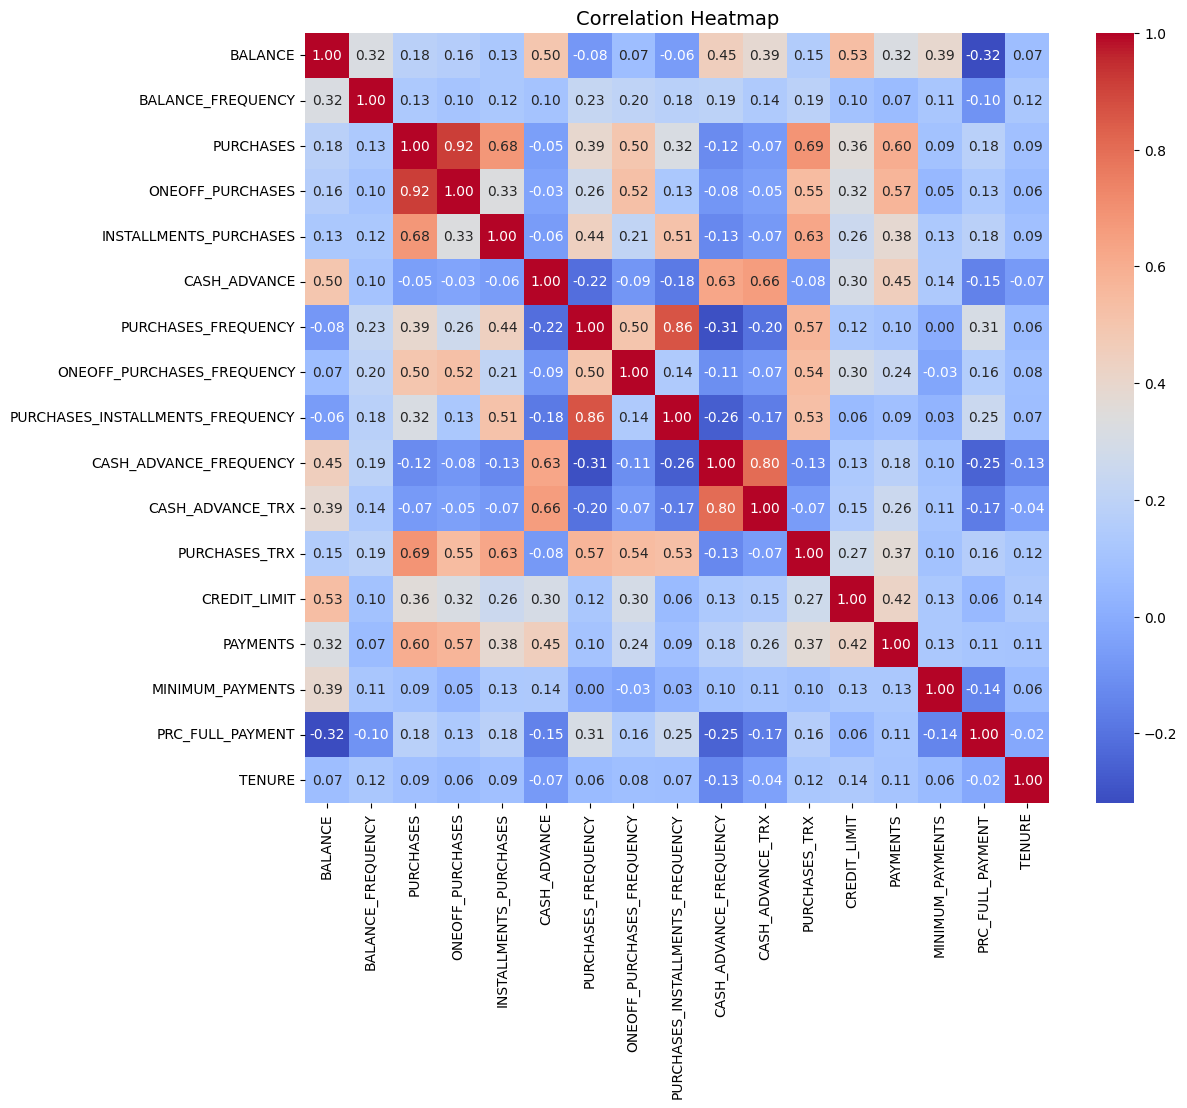

In [24]:
# Create a correlation matrix from the data.
corrMat = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corrMat,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap',fontsize=14)
plt.show()

**Correlation Plot Commentary**

The most highly correlated variables are PURCHASES and ONEOFF_PURCHASES, which suggest most customers' purchases are done in single transactions. 

From there, the next highly correlated variables are PURCHASES_FREQUENCY and PURCHASES_INSTALLMENTS_FREQUENCY, which measure the frequency of purchases and the frequency of purchases made in installments (both on a scale from 0-1). 

Other highly correlated variables include: CASH_ADVANCE and CASH_ADVANCE_TRX (which tracks the number of purchases made with "cash in advance"), CASH_ADVANCE_TRX and CASH_ADVANCE_FREQUENCY (which is the frequency of purchases made with "cash in advance"). These are understandable, since they all relate the amount of cash a customer is provided in advance.

More interestingly, PURCHASES and PAYMENTS are positively correlated. Their subsidiaries, ONEOFF_PURCHASES (maximum purchase amount in one payment) and INSTALLMENTS_PURCHASES (total purchases marked as "in installments") are also positively correlated with PAYMENTS. This may suggest (though we are well aware that correlation $\neq$ causation) that someone making more purchases is also likely to make more payments. Intuitively, I don't know how I feel about that.

From this plot, I am going to remove some features which are highly correlated, keeping the ones I think are more important to the dataset.

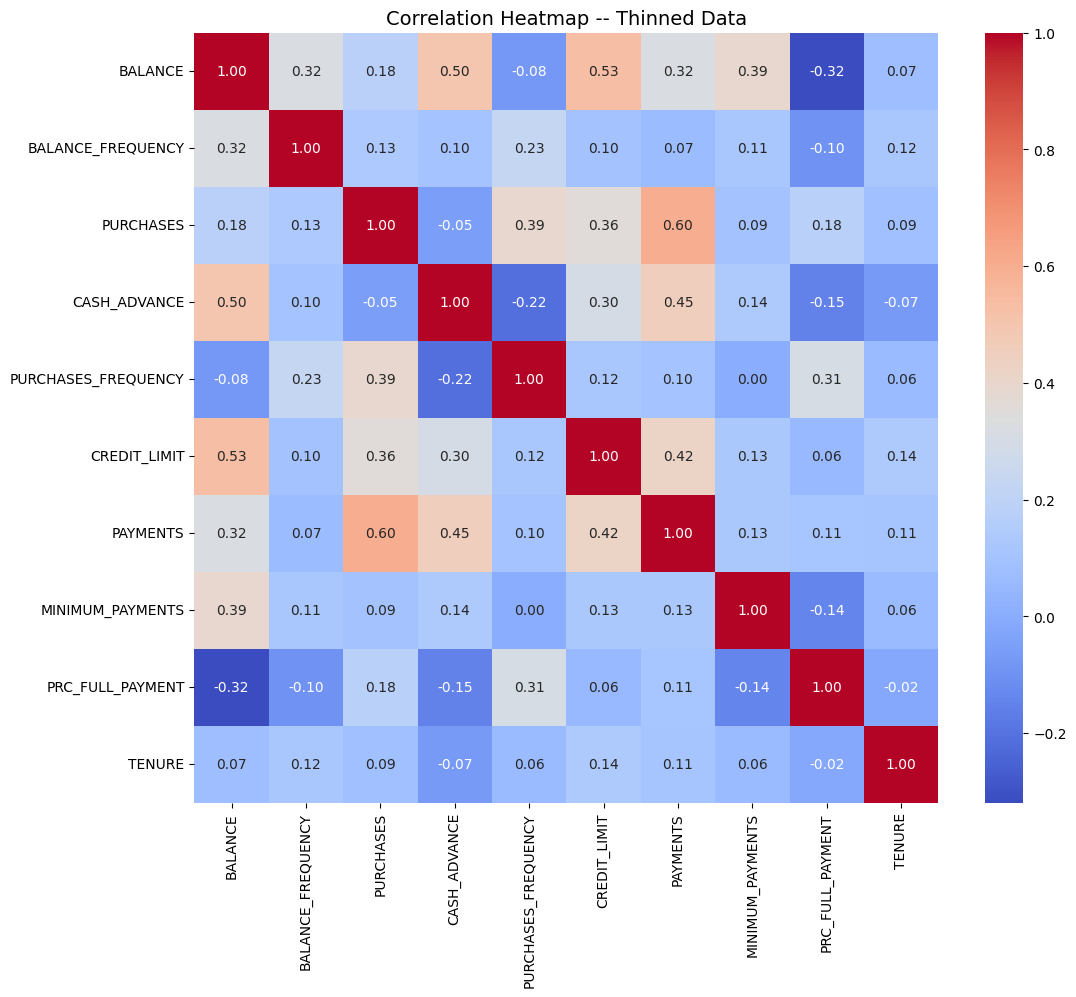

In [8]:
# Remove some features.
dfThin = df.drop(columns=['CASH_ADVANCE_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY',
                         'ONEOFF_PURCHASES_FREQUENCY','ONEOFF_PURCHASES','PURCHASES_TRX',
                         'INSTALLMENTS_PURCHASES','CASH_ADVANCE_TRX'])

corrMat = dfThin.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corrMat,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap -- Thinned Data',fontsize=14)
plt.show()

In the end, I removed columns where the correlation was > 0.6 with some other column, based on my best judgement of which of the remaining was most "important."

## Step 1C: Preprocessing (Scaling)

Since KMeans clustering is so reliant on distances to determine the clusters, scaling the data is an absolute must. I am going to use one of the most common methods: StandardScaler.

In [9]:
# Scale the data.
scaler = StandardScaler().fit(dfThin)
scaleDat = scaler.transform(dfThin)

# Step 2: Building the Model

## Step 2A: Selecting an Appropriate K

One of the most important hyperparameters of the KMeans clustering model is the parameter $k$, denoting the number of clusters. To choose the value of this parameter that minimizes the Within-Cluster Sum of Squares (WCSS). 

WCSS measures how well the data points are clustered around their respective centroids. It is defined as follows:
$$ \text{WCSS} = \sum_{i=1}^k \sum_{j=1}^{n_i} \text{distance}(x_j^i, c_i)^2 $$

where $ \text{distance}(x_j^i, c_i) $ represents the distance between the jth data point $x_j^i$ in the ith cluster and the centroid $c_i$ of that cluster.

Another measure we can use to select an appropriate value of $k$ is the *silhouette score*. The silhouette score is a measure of how similar a point is to its own cluster compared to other clusters. It takes on values from -1 to 1, where larger (positive) values are indicative of good clustering. The silhouette is defined as follows:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i),b(i))} $$

where $a(i)$ represents the average distance between point $i$ and all other points in the same cluster, and $b(i)$ is the smallest mean distance from $i$ to all points in any other cluster.

In [67]:
# Parametric sweep over possible k values
kVals = range(2,11)
kStats = []

for k in kVals:
    kM = KMeans(n_clusters=k,random_state=323)
    labs = kM.fit_predict(scaleDat)
    kStats.append({
        "k" : k,
        "wcss" : kM.inertia_,
        "silScore": silhouette_score(scaleDat,labs)
    })

kStatsDF = pd.DataFrame(kStats)

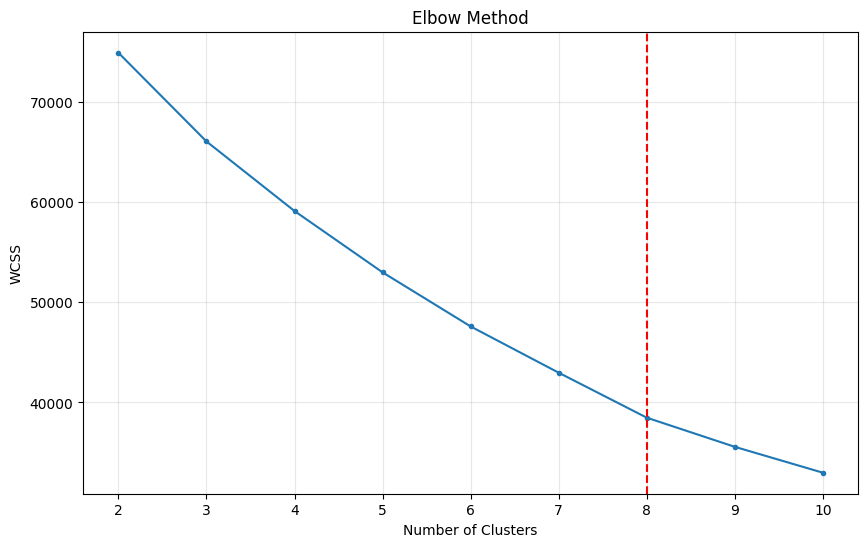

In [71]:
# Make the elbow plot.
plt.figure(figsize=(10,6))
plt.plot(kStatsDF.k,kStatsDF.wcss,marker='.')
plt.axvline(x=8,color='r',linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True,alpha=0.3)
plt.show()

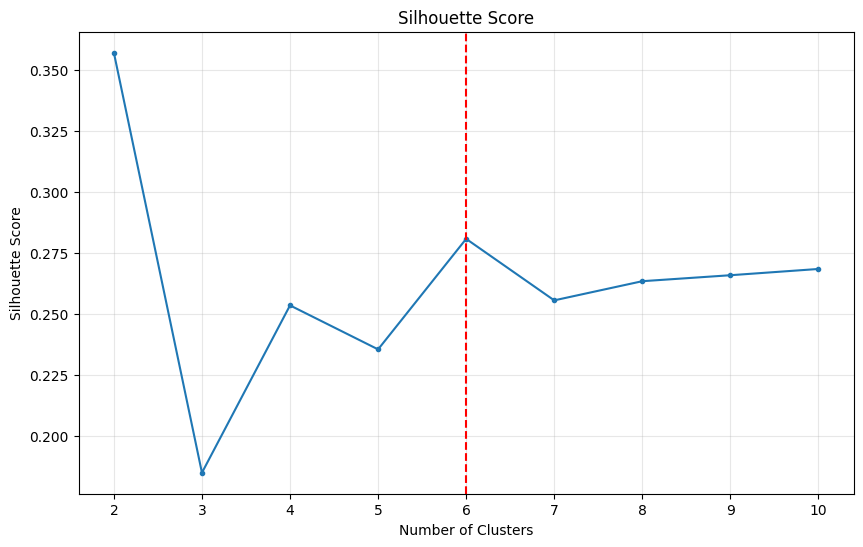

In [70]:
# Make the silhouette plot
plt.figure(figsize=(10,6))
plt.plot(kStatsDF.k,kStatsDF.silScore,marker='.')
plt.axvline(x=6,color='r',linestyle='--')
plt.title('Silhouette Score')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.grid(True,alpha=0.3)
plt.show()

**Optimal K Commentary**

The elbow plot has a very gentle curve, so I'm glad I also plotted the silhouette score. 

Given an initial search range of k = 2-10, I would have guessed the optimal value for $k$ to be 8, but the silhouette score suggests the optimal value of $k$ is 6.

## Step 2B: Optimizing Other Hyperparameters

To ensure we have the best model, I will also look at other hyperparameters, including the initialization method, max number of iterations, and the algorithm selected. For this, I will use SKLearn's GridSearchCV.

Since we have the option, I'll also feed the number of clusters into the GridSearchCV function, just to see if the results are different.

In [72]:
# Define a parameter grid.
pGrid = {
    'n_clusters': range(2,16), # just double-checking the elbow plot
    'init': ['k-means++','random'],
    'max_iter': [100, 200, 300, 400, 500],
    'algorithm': ['lloyd','elkan']
}

# Initialize our model.
kM_search = KMeans(random_state=323)

# Search time!
gS = GridSearchCV(kM_search,param_grid=pGrid)
gS.fit(scaleDat)

# Report the best hyperparameters:
print(f"Best hyperparameters: {gS.best_params_}")

Best hyperparameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 15}


**Grid Search Commentary**

The best parameters, according to the grid search:
* Algorithm: 'lloyd'
* Init: 'k-means++'
* Max iterations: 100
* Number of clusters: 15

I'm not sure how the Grid Search determines the best number of clusters-- if it's also looking at some elbow plot or what-- but it is consistently choosing the largest number, no matter how much I increase it. So let's look at the elbow plot again, holding all of the other hyperparameters constant at their optimal values.

## Step 2C: Revisiting the Optimal K

In [73]:
kNVals = range(4,21)
kNStats = []

for k in kNVals:
    kM = KMeans(n_clusters=k,algorithm='lloyd',init='k-means++',
                max_iter=100,random_state=323)
    labs = kM.fit_predict(scaleDat)
    kNStats.append({
        "k" : k,
        "wcss" : kM.inertia_,
        "silScore": silhouette_score(scaleDat,labs)
    })

kNStatsDF = pd.DataFrame(kNStats)

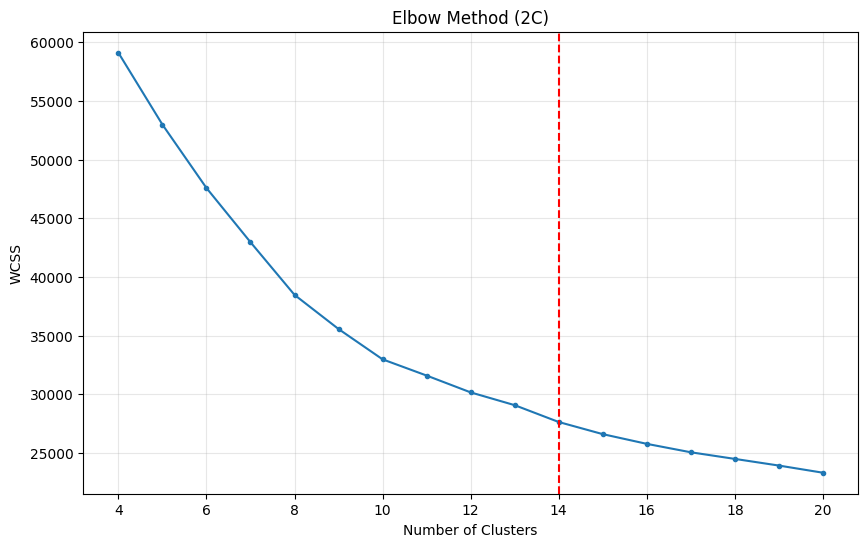

In [75]:
# Make the elbow plot.
plt.figure(figsize=(10,6))
plt.plot(kNStatsDF.k,kNStatsDF.wcss,marker='.')
plt.axvline(x=14,color='r',linestyle='--')
plt.title('Elbow Method (2C)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True,alpha=0.3)
plt.show()

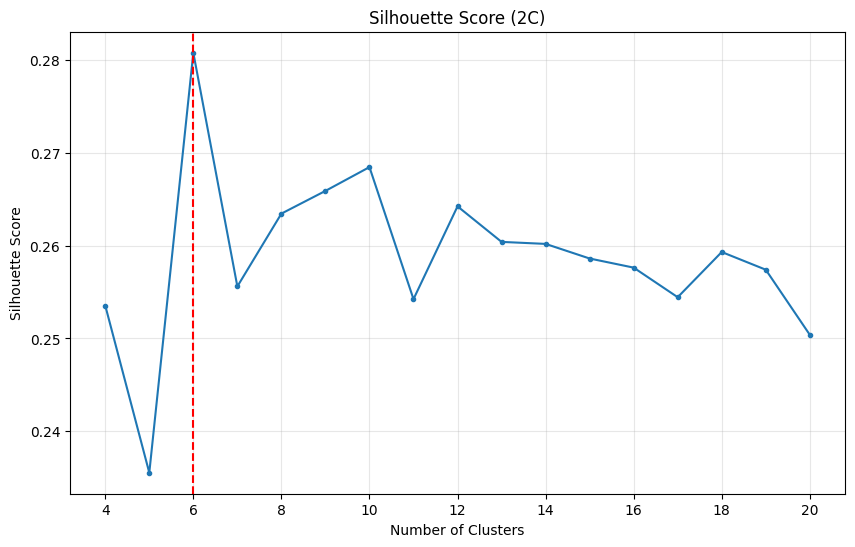

In [77]:
# Make the silhouette plot
plt.figure(figsize=(10,6))
plt.plot(kNStatsDF.k,kNStatsDF.silScore,marker='.')
plt.axvline(x=6,color='r',linestyle='--')
plt.title('Silhouette Score (2C)')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.grid(True,alpha=0.3)
plt.show()

**Revisiting Optimal K Commentary**

Again, the elbow and silhouette plots disagree on the optimal value of $k$. However, the elbow plot does still have a very shallow curve, while the silhouette plot reaches a clear local maximum at $k = 6$. I will take $k = 6$ since it's the smaller number of clusters.

# Step 3: The Final Model

It is finally time! Here we will build the model given the optimal hyperparameters we discovered in the previous section, and then we will investigate the clustered data.

## Step 3A: Build and Train the Final Model

In [10]:
# Create and fit the final model.
kMFinal = KMeans(n_clusters=6,init='k-means++',algorithm='lloyd',
                max_iter=100, random_state=323);

kMFinal.fit(scaleDat);

In [22]:
# Now create an updated dataframe with a new column assigning each customer to a cluster.
dfClustered = dfThin.copy()
dfClustered['CLUSTER'] = kMFinal.labels_

labs = kMFinal.labels_
centroids = kMFinal.cluster_centers_

[1 3 1 ... 5 5 5]


## Step 3B: Investigate the Clustered Data

I want to determine which features from the thinned dataset are the most "important" to determining a cluster so I can better understand the clustered data.

In [23]:
# This code is based on a feature_importances wrapper, cited in "References."
featNames = dfThin.columns
centroids = np.vectorize(lambda x: np.abs(x))(centroids)
iSC = centroids.argsort(axis=1)[:,::-1]

featWeights = {}
for lab, centroid in zip(range(kMFinal.n_clusters),iSC):
    orderFW = centroids[lab][iSC[lab]]
    orderCF = [featNames[feat] for feat in centroid]
    featWeights[lab] = list(zip(orderCF, orderFW))


featWeightsDF = pd.DataFrame(featWeights)
print(featWeightsDF)

                                           0  \
0              (PAYMENTS, 5.679682331360499)   
1             (PURCHASES, 4.947273881289759)   
2         (CREDIT_LIMIT, 2.2603685551605435)   
3           (CASH_ADVANCE, 1.84101298629932)   
4               (BALANCE, 1.610605754695723)   
5  (PURCHASES_FREQUENCY, 0.7648462219488137)   
6     (MINIMUM_PAYMENTS, 0.7003032951846693)   
7     (PRC_FULL_PAYMENT, 0.5994698638640281)   
8              (TENURE, 0.26187079246095957)   
9     (BALANCE_FREQUENCY, 0.211181902722496)   

                                            1  \
0      (PRC_FULL_PAYMENT, 0.4215005252478248)   
1     (BALANCE_FREQUENCY, 0.4213354045760495)   
2          (CREDIT_LIMIT, 0.3248172610181279)   
3                (TENURE, 0.2842496951730336)   
4             (PAYMENTS, 0.21194744173439525)   
5         (CASH_ADVANCE, 0.20480019745501113)   
6              (PURCHASES, 0.146578547929435)   
7              (BALANCE, 0.14067112799062156)   
8     (MINIMUM_PAYMENTS, 0.075

In [24]:
# Group the data by cluster and look at the mean.
dfC_analysis = dfClustered.groupby(['CLUSTER'])
print(dfC_analysis.mean())

             BALANCE  BALANCE_FREQUENCY     PURCHASES  CASH_ADVANCE  \
CLUSTER                                                               
0        4916.814754           0.927298  11573.131736   4839.561345   
1        1271.679749           0.977081    690.037507    549.395531   
2         130.029890           0.361615    332.604579    399.843427   
3        5294.345895           0.982219   1294.346554   3464.007012   
4         197.667184           0.921003   1795.013350     75.871476   
5         912.234543           0.803064    431.036956   1174.077080   

         PURCHASES_FREQUENCY  CREDIT_LIMIT      PAYMENTS  MINIMUM_PAYMENTS  \
CLUSTER                                                                      
0                   0.797320  12718.595041  18175.267689       2496.233831   
1                   0.461335   3312.631362   1119.576775        687.605120   
2                   0.271676   3693.897094   1100.835871        271.386369   
3                   0.437635   8964.34659

**Feature Importance/Cluster Analysis Commentary**

This tells me a lot about the different clusters. For instance:
* Cluster 5 is decided almost entirely based on TENURE -- its customers have a mean tenure of 7.32 years, which is much less than the average for the dataset.
* Cluster 2's most important feature is BALANCE_FREQUENCY, which measures how frequently a customer's balance is updated (likely related to purchase frequency). This cluster had the lowest average balance update frequency, likely indicating they don't often make purchases with this card.
* Cluster 4 was decided by PRC_FULL_PAYMENT, and its members had the highest mean value in this category.
* Clusters 0, 1, and 3 were decided by a combination of features.
* From the statistics above, it appears Cluster 0 represents customers with high credit limits, balances, purchase totals, and cash advances. This cluster probably represents people who use the card frequently for high-value purchases.
* Cluster 3 is very similar to Cluster 0 *except* its members do not have high average payments. They likely carry a larger balance on the card from month-to-month.
* Finally, Cluster 1 are long term customers with low balances, credit limits, and purchase totals.

# Step 4: Discussion/Conclusion

The aim of this project was to attempt to categorize customers from a database of credit card users at a particular company. Given 8,950 customer observations in six months, denoted in 18 variables, I was to determine some clusters for customers which could then be used to inform a marketing campaign. This analysis involved a few steps:
1. Clean and preprocess the data.
2. Optimize the KMeans model through determination of best model hyperparameters, including the number of clusters and KMeans algorithm.
3. Apply the optimized model to the dataset and draw conclusions based on the most important features for each cluster.

Each of these steps is detailed in the notebook above. After applying the optimized model to the dataset, the clusters it created were:
* **Cluster 0:** Customers who regularly use this credit card for high value purchases and cash advances and are approved for high credit limits *and* subsequently pay off those purchases. One could infer these customers are working professionals who use the card for business and make their payments on time.
* **Cluster 1:** These are long term customers with low balances, credit limits, and purchase totals. Perhaps these customers prefer to make purchases using their debit cards or cash.
* **Cluster 2:** Customers who make infrequent purchases with this card. They also tend to have low credit limits and the smallest balances. This card could be a back-up card, or one used for specific, infrequent purchases such as those with a particular business.
* **Cluster 3:** Cluster 3 was very similar to Cluster 0 *except* its members do not have high average payments, and the card is used less frequently. One could infer the members of this cluster are unable to make payments as often, as their cash advance totals were second only to Cluster 0 members.
* **Cluster 4:** The members of this cluster had paid the most toward their full balance. These customers were also likely to have a low cash-advance balance and high purchase frequency. One might call them particularly fiscally responsible.
* **Cluster 5:** The average tenure of a customer in this dataset was 11.5 years, yet this cluster had an average tenure of only 7.3 years. They are what we might consider "new customers."

The descriptions of the clusters highlight how complicated a person's financial history and current situation can be-- if I'd let it, I'm certain the KMeans algorithm would have chosen a higher number of clusters, since finances are so individual. However, my analysis (and keeping in mind the endgame of said analysis) suggested 6 clusters to be a good number for this dataset, and these 6 groups of users are generic enough that they could inform marketing strategies for this company. 

If I were to continue this project, I would attempt a few excursions: first, I would see how the optimal parameters and the clusters themselves would differ (if at all) when utilizing the full dataset, rather than the thinned version. I attempted to choose features for this model which would yield the most information about the dataset without repetition (where the correlation between variables would, in effect, give the model the same information twice), since I know the curse of dimensionality applies especially to kMeans models. I could also try PCA to reduce the features used in this model. Secondly, I would like to see how other clustering models (such as hierarchical clustering) would work with this data.

# References

This notebook helped me get started: https://www.kaggle.com/code/tanaykotecha/creditcard-clustering

This notebook was also useful: https://www.kaggle.com/code/diegohurtadoo/customer-segmentation-kmeans-parameter-tuning

Elbow Method for Clustering with KMeans: http://geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

Feature Importance in KMeans Clustering: https://github.com/YousefGh/kmeans-feature-importance/blob/kmeans-feature-importance-v01/kmeans_interp/kmeans_feature_imp.py